In [ ]:
#Adapted from the Keras Example https://keras.io/examples/structured_data/collaborative_filtering_movielens/

In [241]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt 

# Week 6.1- Embeddings for Recommendation 

Here we'll see how to train our simple **Dot Product** model, along with our **user embeddings** and **item embeddings** using the **Keras** library. As before, we'll be checking out the **MovieLens** dataset 

## Loading in the Dataset

First we load in the small version of the dataset. As this is a **Collaborative Filtering** approach, we are interested in the **ratings.csv**, which has all over ratings made by each user.

In [242]:
df = pd.read_csv("data/ml-latest-small/ratings.csv")

In [243]:
len(df)

100004

In [244]:
df.tail(100)

,userId,movieId,rating,timestamp
99904,671,590,4.0,1065149296
99905,671,608,4.0,1064890575
99906,671,745,4.0,1065149085
99907,671,919,4.0,1065149458
99908,671,1035,5.0,1065149492
...,...,...,...,...
99999,671,6268,2.5,1065579370
100000,671,6269,4.0,1065149201
100001,671,6365,4.0,1070940363
100002,671,6385,2.5,1070979663


## Preprocessing 

What we have in the dataset is a list of **userId** and **movieId** pairs loaded into a ``Pandas`` DataFrame. 

As we said before, you can think of an embedding layer as a **one-hot encoding** layer the size of your **vocabulary**, followed by a **fully connected layer** the size of your embedding. 

When we make the embedding, we will need a way of mapping back from **indexes** in the **one-hot encoding** back to the ids for the users and movies. 

### Vocabulary 

In order to make the vocabulary (all the unique ids), we can use the ``unique()`` function in ``Pandas``

In [245]:
user_ids = df["userId"].unique().tolist()
movie_ids = df["movieId"].unique().tolist()

In [246]:
len(movie_ids)

9066

In [247]:
#non-sequential list of ids
movie_ids[:6]

[31, 1029, 1061, 1129, 1172, 1263]

### Dictionary Comprehensions 

We've seen ``Dictionaries`` (e.g. when looking at JSON from REST APIs). This is a collection like a ``List``, but instead of using indexes to access data (**values**), we use **keys**. 

We've also seen ``List Comprehensions``, a short hand way to iterate through an existing collection and make a new ``List``. 

As we want something where we can use an arbitrary string/number (e.g. a movie or user id) to look up an index, a ``Dictionary`` seems like a good data structure to use. We can declare dictionaries manually (see below), but it would be much quicker and cleaner to use the information we already have to make this.

In [248]:
#manually making the dictionary
movie_id_to_index = {
    31:1,
    1029: 2,
    1061: 3
}

#use a movie id to look up the index
movie_id_to_index[31]

1

Like the ``List Comprehension``, the ``Dictionary Comprehension`` iterates through a given collection, does some calculation and stores new values in a new collection. 

In this case, we need to return both a ``Key`` and a ``Value`` for each item. 

```
a = [1,2,3]
b = {i:i+1 for i in a} 
```

is the same as 

```
a = [1,2,3]
b = {}
for i in a:
    b[i] = i+1
```

where we end up with the ``Dictionary``

```
{
    1: 2,
    2: 3,
    3: 4
}
```

Below, we combine the dictionary comprehension with the ``enumerate()`` function to return the id (x) and the index (i) and store them in a new dictionary 

In [249]:
#make a dictionary mapping ids (keys) to indexes (values)
user_id_to_index = {x: i for i, x in enumerate(user_ids)}
movie_id_to_index = {x: i for i, x in enumerate(movie_ids)}

In [250]:
df["user_index"] = [user_id_to_index[i] for i in df["userId"]]
df["movie_index"] = [movie_id_to_index[i] for i in df["movieId"]]

In [251]:
df.head(5)

,userId,movieId,rating,timestamp,user_index,movie_index
0,1,31,2.5,1260759144,0,0
1,1,1029,3.0,1260759179,0,1
2,1,1061,3.0,1260759182,0,2
3,1,1129,2.0,1260759185,0,3
4,1,1172,4.0,1260759205,0,4


In [252]:
df["rating"].describe()

count    100004.000000
mean          3.543608
std           1.058064
min           0.500000
25%           3.000000
50%           4.000000
75%           4.000000
max           5.000000
Name: rating, dtype: float64

In [253]:
from sklearn.preprocessing import MinMaxScaler
#Pick the Range!
df["rating"] = MinMaxScaler().fit_transform(df["rating"].values.reshape(-1, 1))

In [254]:
df["rating"].describe()

count    100004.000000
mean          0.676357
std           0.235125
min           0.000000
25%           0.555556
50%           0.777778
75%           0.777778
max           1.000000
Name: rating, dtype: float64

## Training Set

We are making a **predictive model** that will take a **user** and **movie** and return a **rating**. 

For our training, we will make a dataset using the information we already know. In this context, our input feautres (``x``) are the movie and user indexes, and the our output (``y``) is the rating. 

We make a train - test split of ``10%`` to validate our model. 

In [255]:
from sklearn.model_selection import train_test_split
#inputs
x = df[["user_index", "movie_index"]]

#outputs
y = df["rating"]

#get train-test split
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.1, random_state=42)


## Making a Custom Model 

Previously in ``Keras`` we have used to pre-existing layers, connecting them all together in using the [Sequential](https://keras.io/guides/sequential_model/) object. This allows us to fit together layers that pass information forwards in a structure that works for most **Neural Networks**.

Partly for reasons of broadening our horizons, and partly due to many Tensorflow based issues, we are going to introduce you to what is fastly becoming the most popular machine learning library, ``PyTorch``. 

Luckily for us, the API (the functions, the structure of models etc..) are very similar across a lot of the leading libraries.

``PyTorch`` has a [Module]() object which we can **subclass**. Without getting too bogged down in the details of **Object Oriented Programming**, essentially what this means is we can take the **existing functionality** from this object and **override** certain functions to add in custom behaviour.

Using the ``Module`` structure, we have something that can take advantage of a lot the things that are built into the ``PyTorch`` library. It can be trained, can have layers, can have parameters that can be optimised.

**But**, we can also add in our own functionality. 

The two main functions we want to override and these are 

1. ``def __init__()``
    
    * This is called **once** when the object is first made. We can use this to define our layers 
    

2. ``def forward()``

    * This is called everytime we want to make a forwards pass. This means it takes some **inputs** and returns some **outputs**. This is called during training, or for inference on a trained model. 
    
### LouisNet

Below, we show an **incredibly simple model**, but it should help you get an intuition for what function is called at when in the training process

We can see the ``__init__()`` is called once, and then the ``call()`` is called **once per batch**, where we get the inputs for this batch and return some outputs

This model doesnt actually have any parameters to train, its more to demonstrate the subclassing principle in the simplest terms

In [ ]:
#install libraries (only do this once!)
!pip install torch torchvision torchaudio

#done

In [256]:
#import library

import torch

In [257]:
#define class and subclass torch.nn.Module
class LouisNet(torch.nn.Module):
    
    #override __init__()
    def __init__(self):
        super().__init__()
        print("__init__ called")

    #override forward()
    def forward(self, inputs):
        print("\nforwards pass (new batch)")
        print(inputs, "\n")
        #return the output (its just the input, unchanged)
        return inputs
    
#make a new instance of LouisNet
louisNet = LouisNet()
loss_fn = torch.nn.MSELoss()

#fake dataset
x = torch.FloatTensor([[1], [2], [3], [4]])
y = torch.FloatTensor([[2], [3], [4], [5]])

#do a forwards pass
prediction = louisNet(x)
loss = loss_fn(prediction, y)

__init__ called

forwards pass (new batch)
tensor([[1.],
        [2.],
        [3.],
        [4.]]) 



## The Dot Product Recommender Model

Lets remember the model we're trying to make. 


```
Predicted Rating = Dot Product(user_vector, item_vector) + user_bias + item_bias
```


Our target is to find a vector for each movie and user so that their dot product (+ their biases) is an accurate prediction for the rating that user would make for that movie. 

Each of these vectors will be contained in a matrix, that we call an **embedding**


### The Embedding Layer 

Again, you can think of an embedding layer as a **one-hot encoding** layer the size of your **vocabulary**, followed by a **fully connected layer** the size of your embedding. 

Luckily, ```PyTorch``` has a layer already we can use, all we have to say is 

1. How many items we have (vocabulary size)

2. The size of the embedding 

You might use something between 10-300, and this is something you will have to tune

### New Arguments for ``__init__``

Again, we will override the ```__init__()``` function, but this time we will add in some extra arguments. We can use this to pass in 

1. Number of users 

2. Number of movies

3. Size of Embedding

These get passed in when we make the new object 

```
model = RecommenderNet(num_users, num_movies, EMBEDDING_SIZE)

```

### Saving Variables and ```self```

Finally, the last **Object-oriented** concept we'll need allows us to save things within the object. These are sometimes called ``instance variables`` or ``fields``, but the main thing you need to know is **these are like the variables we use all the time to store objects and data**, apart from they belong to the object, and only work within this context 

We use the keyword ```self``` within the object to refer to itself. We can use this to make layers in the ```__init__()``` function, store them in the object, and then reuse and update them in the ```forward()``` function.

On every forwards pass (see ``forward()`` below)

1. We take a batch of ``users`` and ``movies``


2. Run them through the normal embedding and bias embedding layers respectively 


3. Get the vectors for each out 


4. Get the dot product of the user and movie vectors 


5. Add the biases 


6. Run through a sigmoid


7. Return!

In [258]:
class RecommenderNet(torch.nn.Module):
    def __init__(self, num_users, num_movies, embedding_size=20):
        super().__init__()
        self.user_embedding = torch.nn.Embedding(num_users, embedding_size)
        self.user_bias = torch.nn.Embedding(num_users, 1)
        self.movie_embedding = torch.nn.Embedding(num_movies, embedding_size)
        self.movie_bias = torch.nn.Embedding(num_movies, 1)
        self.sig = torch.nn.Sigmoid()

    def forward(self, inputs):
        #split out indexes
        user_indexes = inputs[:, 0]
        movie_indexes = inputs[:, 1]
        #forward pass on embedding layer
        user_vector = self.user_embedding(user_indexes)
        user_bias = self.user_bias(user_indexes).flatten()
        movie_vector = self.movie_embedding(movie_indexes)
        movie_bias = self.movie_bias(movie_indexes).flatten()

        #dot product
        dot = (user_vector * movie_vector).sum(1)
        with_bias = dot + user_bias + movie_bias

        #activation function
        output = self.sig(with_bias)
        return output

## Lets test it!

### Set up model

In [259]:
#pick embedding size
EMBEDDING_SIZE = 16

#make new object (calls __init__())
num_users = len(user_ids)
num_movies = len(movie_ids)
model = RecommenderNet(num_users, num_movies, EMBEDDING_SIZE)

### Training and Datasets in PyTorch

PyTorch requires a little bit of manual set up for the training loop that we got for free in ``Keras`` with the ``fit()`` function. 

Below we see two for loops, one that loops round every epoch (once through the entire dataset) and inside that that loops through each batch (a subset of a chosen size).

``PyTorch`` gives us a ``DataLoader`` object which helps with the batching process.

Within that inner loop we pass in part of the training set, calculate the loss and update the weights based on this. 

In [260]:
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

#make a subclass to hold our dataset (movie - user pairs (input) and a rating (label))
class MoviesDataset(Dataset):
    def __init__(self, X,y):
        self.X = torch.IntTensor(X)
        self.y = torch.FloatTensor(y)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
            return self.X[idx], self.y[idx]

In [261]:
#use our train - validation split to make DataLoader objects
train_dl = DataLoader(MoviesDataset(x_train.values, y_train.values), batch_size=64, shuffle=True)
validation_dl = DataLoader(MoviesDataset(x_val.values, y_val.values), batch_size=64, shuffle=True)


In [262]:
epochs = 10
#use mean squared error as a loss function
loss_fn = torch.nn.MSELoss()
#use the Adam algorithm to update the weights based on the loss
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [263]:
#use a for loop to repeat for the desired number of epochs
for i in range(epochs):

    model.train(True)

    #use a for loop for each batch (provided by the DataLoader)
    running_loss = 0.0
    for (index, batch) in enumerate(train_dl):

        #get batch
        inputs, labels = batch
        model.zero_grad()

        #forward pass
        prediction = model(inputs)

        #get loss
        loss = loss_fn(prediction, labels)

        #update the weights (back prop)
        loss.backward()
        optimizer.step()
        running_loss += loss

    avg_loss = running_loss / (index + 1)

    model.train(False)

    #now try running with the validation set (no need to update weights, just get loss)

    running_vloss = 0.0
    for index, vdata in enumerate(validation_dl):
        vinputs, vlabels = vdata
        voutputs = model(vinputs)
        vloss = loss_fn(voutputs, vlabels)
        running_vloss += vloss

    avg_vloss = running_vloss / (index + 1)
    print('Loss {} Validation Loss {}'.format(avg_loss, avg_vloss))

Loss 0.16915658116340637 Validation Loss 0.11316408962011337
Loss 0.0749819353222847 Validation Loss 0.08329208940267563
Loss 0.047988228499889374 Validation Loss 0.07079862803220749
Loss 0.037119921296834946 Validation Loss 0.06573833525180817
Loss 0.03126109018921852 Validation Loss 0.0638611763715744
Loss 0.0278208889067173 Validation Loss 0.06324928998947144
Loss 0.02546476013958454 Validation Loss 0.0629272386431694
Loss 0.02359595149755478 Validation Loss 0.06412762403488159
Loss 0.02260192111134529 Validation Loss 0.06289590150117874
Loss 0.021717408671975136 Validation Loss 0.06425854563713074


### Save and Reload models

We can save the weights of our model (the important parts that we have learned) to file so we don't have to train again in future

We can then load them into a new model from file. 

In [264]:
torch.save(model.state_dict(), 'model_weights.pth')

In [265]:
model = RecommenderNet(num_users, num_movies, EMBEDDING_SIZE)
model.load_state_dict(torch.load('model_weights.pth'))
model.eval()


RecommenderNet(
  (user_embedding): Embedding(671, 16)
  (user_bias): Embedding(671, 1)
  (movie_embedding): Embedding(9066, 16)
  (movie_bias): Embedding(9066, 1)
  (sig): Sigmoid()
)

### Accessing the Embeddings 

We can access the **embedding layers** in our model object. This is the embedding and we can see is has a shape of ```num_users x EMBEDDING_SIZE```

In [266]:
num_users, EMBEDDING_SIZE, model.user_embedding 

(671, 16, Embedding(671, 16))

### Making Predictions 

Now, we can use our trained model to make predictions, and with the predicted ratings, we can pick some recommendations!

In order to get the ratings for all movies for a given user, we need to get pass in our data in the form 

```
[
    [user_index, movie_1_index],
    [user_index, movie_2_index],
    [user_index, movie_3_index],
    .....
]

```

In [267]:
#get the movie data so we can map back to the names
movie_data = pd.read_csv("data/ml-latest-small/movies.csv")
movie_data.columns

Index(['movieId', 'title', 'genres'], dtype='object')

### Making predictions and `argsort()`

Once we have the predicted ratings for each film, we need to get the **Top N**

Here we use `np.argsort()`, which does the sort based on the **ratings** but returns the **indexes** rather than the **ratings themselves**. We can then use this to look up the `movie_ids` and then the `title`.

In [268]:
def get_top_n(user = 0, n = 10):
    #get movie names
    top_n_indexes = get_top_n_indexes(user, n)
    top_n = get_names_for_indexes(top_n_indexes)
    return top_n

def get_names_for_indexes(indexes):
    return [movie_data[movie_data["movieId"]==movie_ids[i]]["title"].item() for i in indexes]

def get_top_n_indexes(user = 0, n = 10):
    #for one user, make a pair with every movie index
    x = torch.IntTensor([[user, i] for i in np.arange(num_movies)])

    #predict
    predicted_ratings = model(x)

    #get top-n indexes
    top_n_indexes = predicted_ratings.argsort()[-n:]
    return top_n_indexes

In [269]:
#random users top 10
get_top_n(np.random.randint(num_users))

['Beauty and the Beast (La belle et la bête) (1946)',
 'Holy Motors (2012)',
 'Innocence (2000)',
 'Land of Silence and Darkness (Land des Schweigens und der Dunkelheit) (1971)',
 'Something the Lord Made (2004)',
 'Punch-Drunk Love (2002)',
 'Hands in the Air (2010)',
 'Vacancy (2007)',
 'Neighbouring Sounds (O som ao redor) (2012)',
 'Willie & Phil (1980)']

# Assessed Assignment 2

Please remember to comment your code clearly, submit ``.ipynb`` 

## Task 1

We're going to ask you take the trained model and write the code to make two metrics - **Diversity** and **Novelty**. You should end up with **one statistic** for each that tells you something about the recommendations of the trained model based on the **whole dataset**.


#### Pro Tip

This will take quite a long time to run on the whole dataset, so start off by trying to get the code to work for **one user**, then expand to **two users**, then **every user**.

### Diversity 

This tells us what the mean diversity (inverse of the similarity, based on movie embeddings) between each film in every users Top 10 films is. 

1. Calculate every user's top 10


2. For each top 10, get the embedding for each film then use this to calculate the similarity matrix


3. Invert similarity to get the difference


4. Get mean difference for each top 10 


5. Report the mean for whole dataset (every top 10)

In [271]:
#getting each users top ten films
ten_films = []
for index, user in enumerate(user_ids):
    if index < len(user_ids)-1:
        user_films = {'User': user, 'Top 10 Films': get_top_n(user, 10)}
        ten_films.append(user_films)

ten_films_df = pd.DataFrame(ten_films)

In [272]:
ten_films_df #taking a look at the data

,User,Top 10 Films
0,1,"[Sky Captain and the World of Tomorrow (2004),..."
1,2,"[Afro Samurai (2007), Good Earth, The (1937), ..."
2,3,"[One Piece Film: Strong World (2009), Whore (1..."
3,4,"[28 Up (1985), Eraserhead (1977), Let It Ride ..."
4,5,"[Art of Getting By, The (2011), Ruby in Paradi..."
...,...,...
665,666,"[Stroszek (1977), Aguirre: The Wrath of God (A..."
666,667,"[House (1986), Merry Madagascar (2009), Doom G..."
667,668,"[My Best Friend (Mon meilleur ami) (2006), The..."
668,669,[Hearts of Darkness: A Filmmakers Apocalypse (...


In [274]:
#first need to calculate the index of every film
ten_films_indexes = []
for index, user in enumerate(user_ids):
    if index < len(user_ids)-1:
        user_films_indexes = get_top_n_indexes(user, 10)
        ten_films_indexes.append(user_films_indexes)
        
ten_films_indexes_df = pd.DataFrame({'Indexes': ten_films_indexes})

In [275]:
ten_films_indexes_df #taking a look at our data from above #we're missing one value

,Indexes
0,"[tensor(1425), tensor(4547), tensor(7798), ten..."
1,"[tensor(4072), tensor(5565), tensor(7864), ten..."
2,"[tensor(7265), tensor(2877), tensor(7220), ten..."
3,"[tensor(4117), tensor(1977), tensor(2822), ten..."
4,"[tensor(8749), tensor(2535), tensor(8802), ten..."
...,...
665,"[tensor(7160), tensor(2421), tensor(1730), ten..."
666,"[tensor(2594), tensor(3961), tensor(2099), ten..."
667,"[tensor(4276), tensor(9033), tensor(9037), ten..."
668,"[tensor(1443), tensor(4136), tensor(4298), ten..."


In [276]:
ten_films_df = pd.concat([ten_films_df, ten_films_indexes_df], axis=1) #put the two dataframes together

In [277]:
#getting the embeddings for each film using the films indexes and our model.movie_embeddings function
all_embeddings = []

for indexes in ten_films_indexes_df['Indexes']:
    user_embeddings = []
    for i in indexes:
        movie_embeddings = []
        for user_id in user_ids:
            embeddings = model.movie_embedding(torch.LongTensor([i]))
            embeddings = embeddings.detach().numpy()
            movie_embeddings.extend(embeddings)
        user_embeddings.extend(movie_embeddings)
    all_embeddings.append(user_embeddings[0])

In [278]:
all_embeddings_df = pd.DataFrame({'Film Embeddings': all_embeddings}) #creating a dataframe of our values

In [279]:
all_embeddings_df #our embbedings for every film 

,Film Embeddings
0,"[-1.3889476, 1.5145048, 0.56558615, -1.501288,..."
1,"[-0.04745067, 0.04122448, 2.3287525, -0.681692..."
2,"[-0.044180345, 1.6639876, -2.1735666, 1.466680..."
3,"[-0.81497556, 0.85872287, 0.07991368, 2.725548..."
4,"[-1.2480296, 1.1238309, -2.3248196, -1.3294555..."
...,...
665,"[0.57708687, -1.3742363, 1.3101921, -0.2090393..."
666,"[1.0567771, 1.2339802, 0.32988888, -2.021433, ..."
667,"[-1.4451815, -0.37199348, -1.9954224, 3.061271..."
668,"[-1.2672199, -1.9154602, -0.99919957, -1.35825..."


In [280]:
#append our film embeddings to our full dataset showing each user, films, indexes, and embeddings
ten_films_df = pd.concat([ten_films_df, all_embeddings_df], axis=1)

In [281]:
#Import cosine similarity
from sklearn.metrics.pairwise import cosine_similarity

In [282]:
#for this section, I altered code from here in addition to my understanding of cosine similarities from data science notebook week 3: https://stackoverflow.com/questions/51691994/how-to-use-np-zeros-as-iterator-in-python
n = len(all_embeddings_df)
similarity_matrix = np.zeros((n, n))
diversity_matrix = np.zeros((n, n))
mean_difference = []

for i in range(n):
    for j in range(n):
        values_i = np.array(all_embeddings_df['Film Embeddings'][i]).flatten() #flatten the arrays so they are in the right format
        values_j = np.array(all_embeddings_df['Film Embeddings'][j]).flatten()
        
        # Calculate similarity between df['values'][i] and df['values'][j]
        similarity = cosine_similarity([all_embeddings_df['Film Embeddings'][i]], [all_embeddings_df['Film Embeddings'][j]])
        diversity = 1-similarity
        
        # Assign similarity and diversity to matrix
        similarity_matrix[i, j] = similarity
        diversity_matrix[i, j] = diversity

print(len(similarity_matrix))
print(len(diversity_matrix)) #this looks good, so we can append it to our dataframe

670
670


In [283]:
similarity_matrix #taking a look

array([[ 0.99999994, -0.05854823, -0.43747166, ..., -0.05195138,
         0.02465503,  0.19213013],
       [-0.05854823,  0.99999976, -0.1827096 , ...,  0.05765731,
         0.12166092, -0.02425304],
       [-0.43747166, -0.1827096 ,  1.        , ...,  0.21840382,
        -0.10139649,  0.12744766],
       ...,
       [-0.05195138,  0.05765731,  0.21840382, ...,  1.        ,
        -0.08206091,  0.01918522],
       [ 0.02465503,  0.12166092, -0.10139649, ..., -0.08206091,
         0.99999988, -0.18724266],
       [ 0.19213013, -0.02425304,  0.12744766, ...,  0.01918522,
        -0.18724266,  1.00000012]])

In [284]:
diversity_matrix #taking a look

array([[ 5.96046448e-08,  1.05854821e+00,  1.43747163e+00, ...,
         1.05195141e+00,  9.75344956e-01,  8.07869852e-01],
       [ 1.05854821e+00,  2.38418579e-07,  1.18270957e+00, ...,
         9.42342699e-01,  8.78339052e-01,  1.02425301e+00],
       [ 1.43747163e+00,  1.18270957e+00,  0.00000000e+00, ...,
         7.81596184e-01,  1.10139644e+00,  8.72552335e-01],
       ...,
       [ 1.05195141e+00,  9.42342699e-01,  7.81596184e-01, ...,
         0.00000000e+00,  1.08206093e+00,  9.80814815e-01],
       [ 9.75344956e-01,  8.78339052e-01,  1.10139644e+00, ...,
         1.08206093e+00,  1.19209290e-07,  1.18724263e+00],
       [ 8.07869852e-01,  1.02425301e+00,  8.72552335e-01, ...,
         9.80814815e-01,  1.18724263e+00, -1.19209290e-07]])

In [285]:
#in this, we are turning the above into dataframes so we can append them to our original dataframe
similarity_matrix_df = pd.DataFrame()
similarity_matrix_df['Similarity'] = similarity_matrix.tolist()

diversity_matrix_df = pd.DataFrame()
similarity_matrix_df['Diversity'] = diversity_matrix.tolist()

In [286]:
similarity_matrix_df #looking at the dataframe we created

,Similarity,Diversity
0,"[0.9999999403953552, -0.058548226952552795, -0...","[5.960464477539063e-08, 1.0585482120513916, 1...."
1,"[-0.058548226952552795, 0.9999997615814209, -0...","[1.0585482120513916, 2.384185791015625e-07, 1...."
2,"[-0.4374716579914093, -0.18270960450172424, 1....","[1.437471628189087, 1.1827095746994019, 0.0, 0..."
3,"[-0.4162212312221527, -0.03427375853061676, 0....","[1.416221261024475, 1.0342737436294556, 0.5261..."
4,"[0.453381210565567, 0.04188942909240723, -0.01...","[0.5466188192367554, 0.9581105709075928, 1.016..."
...,...,...
665,"[-0.22421300411224365, 0.17573419213294983, -0...","[1.2242130041122437, 0.8242658376693726, 1.178..."
666,"[-0.057262301445007324, -0.12694516777992249, ...","[1.0572623014450073, 1.1269451379776, 1.086466..."
667,"[-0.05195137858390808, 0.05765731260180473, 0....","[1.0519514083862305, 0.9423426985740662, 0.781..."
668,"[0.02465502917766571, 0.12166091799736023, -0....","[0.9753449559211731, 0.8783390522003174, 1.101..."


In [287]:
#calculate mean difference for each top 10 
#I used code from this site to help develop this below: https://stackoverflow.com/questions/51080174/applying-lambda-row-on-multiple-columns-pandas
similarity_matrix_df['Mean_Difference'] = similarity_matrix_df.apply(lambda row: np.mean(np.abs(np.array(row['Similarity']) - np.array(row['Diversity']))), axis=1)

In [288]:
similarity_matrix_df #checking the results

,Similarity,Diversity,Mean_Difference
0,"[0.9999999403953552, -0.058548226952552795, -0...","[5.960464477539063e-08, 1.0585482120513916, 1....",0.990030
1,"[-0.058548226952552795, 0.9999997615814209, -0...","[1.0585482120513916, 2.384185791015625e-07, 1....",1.032754
2,"[-0.4374716579914093, -0.18270960450172424, 1....","[1.437471628189087, 1.1827095746994019, 0.0, 0...",1.014716
3,"[-0.4162212312221527, -0.03427375853061676, 0....","[1.416221261024475, 1.0342737436294556, 0.5261...",0.969758
4,"[0.453381210565567, 0.04188942909240723, -0.01...","[0.5466188192367554, 0.9581105709075928, 1.016...",1.046675
...,...,...,...
665,"[-0.22421300411224365, 0.17573419213294983, -0...","[1.2242130041122437, 0.8242658376693726, 1.178...",1.006703
666,"[-0.057262301445007324, -0.12694516777992249, ...","[1.0572623014450073, 1.1269451379776, 1.086466...",1.027090
667,"[-0.05195137858390808, 0.05765731260180473, 0....","[1.0519514083862305, 0.9423426985740662, 0.781...",0.960528
668,"[0.02465502917766571, 0.12166091799736023, -0....","[0.9753449559211731, 0.8783390522003174, 1.101...",1.013531


In [289]:
ten_films_df = pd.concat([ten_films_df, similarity_matrix_df], axis=1) #putting the dataframes together

In [290]:
#take a look at our completed dataframe holding the values for all aspects of diversity
ten_films_df

,User,Top 10 Films,Indexes,Film Embeddings,Similarity,Diversity,Mean_Difference
0,1,"[Sky Captain and the World of Tomorrow (2004),...","[tensor(1425), tensor(4547), tensor(7798), ten...","[-1.3889476, 1.5145048, 0.56558615, -1.501288,...","[0.9999999403953552, -0.058548226952552795, -0...","[5.960464477539063e-08, 1.0585482120513916, 1....",0.990030
1,2,"[Afro Samurai (2007), Good Earth, The (1937), ...","[tensor(4072), tensor(5565), tensor(7864), ten...","[-0.04745067, 0.04122448, 2.3287525, -0.681692...","[-0.058548226952552795, 0.9999997615814209, -0...","[1.0585482120513916, 2.384185791015625e-07, 1....",1.032754
2,3,"[One Piece Film: Strong World (2009), Whore (1...","[tensor(7265), tensor(2877), tensor(7220), ten...","[-0.044180345, 1.6639876, -2.1735666, 1.466680...","[-0.4374716579914093, -0.18270960450172424, 1....","[1.437471628189087, 1.1827095746994019, 0.0, 0...",1.014716
3,4,"[28 Up (1985), Eraserhead (1977), Let It Ride ...","[tensor(4117), tensor(1977), tensor(2822), ten...","[-0.81497556, 0.85872287, 0.07991368, 2.725548...","[-0.4162212312221527, -0.03427375853061676, 0....","[1.416221261024475, 1.0342737436294556, 0.5261...",0.969758
4,5,"[Art of Getting By, The (2011), Ruby in Paradi...","[tensor(8749), tensor(2535), tensor(8802), ten...","[-1.2480296, 1.1238309, -2.3248196, -1.3294555...","[0.453381210565567, 0.04188942909240723, -0.01...","[0.5466188192367554, 0.9581105709075928, 1.016...",1.046675
...,...,...,...,...,...,...,...
665,666,"[Stroszek (1977), Aguirre: The Wrath of God (A...","[tensor(7160), tensor(2421), tensor(1730), ten...","[0.57708687, -1.3742363, 1.3101921, -0.2090393...","[-0.22421300411224365, 0.17573419213294983, -0...","[1.2242130041122437, 0.8242658376693726, 1.178...",1.006703
666,667,"[House (1986), Merry Madagascar (2009), Doom G...","[tensor(2594), tensor(3961), tensor(2099), ten...","[1.0567771, 1.2339802, 0.32988888, -2.021433, ...","[-0.057262301445007324, -0.12694516777992249, ...","[1.0572623014450073, 1.1269451379776, 1.086466...",1.027090
667,668,"[My Best Friend (Mon meilleur ami) (2006), The...","[tensor(4276), tensor(9033), tensor(9037), ten...","[-1.4451815, -0.37199348, -1.9954224, 3.061271...","[-0.05195137858390808, 0.05765731260180473, 0....","[1.0519514083862305, 0.9423426985740662, 0.781...",0.960528
668,669,[Hearts of Darkness: A Filmmakers Apocalypse (...,"[tensor(1443), tensor(4136), tensor(4298), ten...","[-1.2672199, -1.9154602, -0.99919957, -1.35825...","[0.02465502917766571, 0.12166091799736023, -0....","[0.9753449559211731, 0.8783390522003174, 1.101...",1.013531


In [291]:
#report the mean for the whole dataset
dataset_mean = ten_films_df['Mean_Difference'].mean()
print('The Dataset Mean is: ', dataset_mean)

The Dataset Mean is:  1.0003949679787554


### Novelty 

This tells us what the mean popularity (e.g. mean rating) of the films in every users Top 10 films is 

1. Calculate every user's top 10


2. For each top 10, get the mean rating for each film (based on the original **MovieLens Small** dataset (``df = pd.read_csv("ml-latest-small/ratings.csv")``). 


3. Get the mean rating for each top 10.


4. Report the mean for the whole dataset (every top 10).

In [292]:
#take every users top 10
users_top_10 = pd.DataFrame({'Users': ten_films_df['User'], 'Top 10 Films Indexes': ten_films_df['Indexes']})
users_top_10

,Users,Top 10 Films Indexes
0,1,"[tensor(1425), tensor(4547), tensor(7798), ten..."
1,2,"[tensor(4072), tensor(5565), tensor(7864), ten..."
2,3,"[tensor(7265), tensor(2877), tensor(7220), ten..."
3,4,"[tensor(4117), tensor(1977), tensor(2822), ten..."
4,5,"[tensor(8749), tensor(2535), tensor(8802), ten..."
...,...,...
665,666,"[tensor(7160), tensor(2421), tensor(1730), ten..."
666,667,"[tensor(2594), tensor(3961), tensor(2099), ten..."
667,668,"[tensor(4276), tensor(9033), tensor(9037), ten..."
668,669,"[tensor(1443), tensor(4136), tensor(4298), ten..."


In [293]:
#i now want to clean the above, so it'll be in the same format as the movie indexes in our df
def remove_tensor_prefix(value):
    return str(value).replace('tensor(', '').replace(')', '')

In [294]:
#in this we restructure each value in the top 10 films indexes to make on list of all the values, rather than separate tensors
users_top_10['Top 10 Films Indexes'] = users_top_10['Top 10 Films Indexes'].apply(lambda x: [remove_tensor_prefix(value) for value in x])

In [295]:
users_top_10 #it worked, so we can move on! 

,Users,Top 10 Films Indexes
0,1,"[1425, 4547, 7798, 3934, 6245, 8026, 7454, 619..."
1,2,"[4072, 5565, 7864, 3037, 4396, 1884, 7997, 489..."
2,3,"[7265, 2877, 7220, 3284, 7834, 1202, 2151, 186..."
3,4,"[4117, 1977, 2822, 7035, 4276, 2754, 2018, 279..."
4,5,"[8749, 2535, 8802, 7456, 8545, 6778, 3879, 824..."
...,...,...
665,666,"[7160, 2421, 1730, 6313, 8104, 6988, 7724, 439..."
666,667,"[2594, 3961, 2099, 770, 3479, 1733, 6923, 6642..."
667,668,"[4276, 9033, 9037, 5224, 7798, 8153, 4358, 857..."
668,669,"[1443, 4136, 4298, 1112, 7453, 3987, 1684, 740..."


In [296]:
#for each top ten get the mean rating for each film
df #our dataset from the beginning of the notebook

,userId,movieId,rating,timestamp,user_index,movie_index
0,1,31,0.444444,1260759144,0,0
1,1,1029,0.555556,1260759179,0,1
2,1,1061,0.555556,1260759182,0,2
3,1,1129,0.333333,1260759185,0,3
4,1,1172,0.777778,1260759205,0,4
...,...,...,...,...,...,...
99999,671,6268,0.444444,1065579370,670,7005
100000,671,6269,0.777778,1065149201,670,4771
100001,671,6365,0.777778,1070940363,670,1329
100002,671,6385,0.444444,1070979663,670,1331


In [297]:
#first get the mean rating for each film
#the below code was borrowed through adapting this: https://stackoverflow.com/questions/22219004/how-to-group-dataframe-rows-into-list-in-pandas-groupby
grouped_movies_df = df.groupby('movieId')['rating', 'movie_index'].agg(list).reset_index()

# Rename the column to 'user_ratings'
grouped_movies_df = grouped_movies_df.rename(columns={'rating': 'user_ratings'})

/var/folders/dy/dk1fgq_j19db23lnh6nc3n3m0000gn/T/ipykernel_7623/311799615.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  grouped_movies_df = df.groupby('movieId')['rating', 'movie_index'].agg(list).reset_index()


In [298]:
grouped_movies_df #taking a look at our data

,movieId,user_ratings,movie_index
0,1,"[0.5555555555555556, 0.7777777777777777, 1.0, ...","[417, 417, 417, 417, 417, 417, 417, 417, 417, ..."
1,2,"[0.3333333333333333, 0.5555555555555556, 0.333...","[650, 650, 650, 650, 650, 650, 650, 650, 650, ..."
2,3,"[0.7777777777777777, 0.5555555555555556, 0.555...","[319, 319, 319, 319, 319, 319, 319, 319, 319, ..."
3,4,"[0.5555555555555556, 0.5555555555555556, 0.555...","[2084, 2084, 2084, 2084, 2084, 2084, 2084, 208..."
4,5,"[0.8888888888888888, 0.5555555555555556, 0.555...","[651, 651, 651, 651, 651, 651, 651, 651, 651, ..."
...,...,...,...
9061,161944,[1.0],[6027]
9062,162376,[0.8888888888888888],[4080]
9063,162542,[1.0],[8635]
9064,162672,[0.5555555555555556],[8636]


In [299]:
#we now need to fix the movie_index value to only include one
grouped_movies_df['movie_index'] = grouped_movies_df['movie_index'].apply(lambda x: x[0])

In [300]:
grouped_movies_df #great, now we have our indexes, we can continue

,movieId,user_ratings,movie_index
0,1,"[0.5555555555555556, 0.7777777777777777, 1.0, ...",417
1,2,"[0.3333333333333333, 0.5555555555555556, 0.333...",650
2,3,"[0.7777777777777777, 0.5555555555555556, 0.555...",319
3,4,"[0.5555555555555556, 0.5555555555555556, 0.555...",2084
4,5,"[0.8888888888888888, 0.5555555555555556, 0.555...",651
...,...,...,...
9061,161944,[1.0],6027
9062,162376,[0.8888888888888888],4080
9063,162542,[1.0],8635
9064,162672,[0.5555555555555556],8636


In [301]:
#getting the mean for every movie id
#borrowed the same line of code when finding the mean difference between similarity and difference in diversity
grouped_movies_df['Mean Rating'] = grouped_movies_df.apply(lambda row: np.mean(np.abs(np.array(row['user_ratings']))), axis=1)

In [302]:
grouped_movies_df #taking a look at the data

,movieId,user_ratings,movie_index,Mean Rating
0,1,"[0.5555555555555556, 0.7777777777777777, 1.0, ...",417,0.749438
1,2,"[0.3333333333333333, 0.5555555555555556, 0.333...",650,0.644860
2,3,"[0.7777777777777777, 0.5555555555555556, 0.555...",319,0.591337
3,4,"[0.5555555555555556, 0.5555555555555556, 0.555...",2084,0.418803
4,5,"[0.8888888888888888, 0.5555555555555556, 0.555...",651,0.615079
...,...,...,...,...
9061,161944,[1.0],6027,1.000000
9062,162376,[0.8888888888888888],4080,0.888889
9063,162542,[1.0],8635,1.000000
9064,162672,[0.5555555555555556],8636,0.555556


In [303]:
users_top_10['Film Ratings'] = [[] for _ in range(len(users_top_10))]

# Iterate through each row in users_top_10
for index, row in users_top_10.iterrows():
    # Iterate through each value in the top 10 films column
    for value in row['Top 10 Films Indexes']:
        value = int(value) #have to make it an integer so we can compare
        # Check if the value is present in grouped_movies_df
        if value in grouped_movies_df['movie_index'].values:
            # Retrieve the rating value from grouped_movies_df
            associated_value = grouped_movies_df.loc[grouped_movies_df['movie_index'] == value, 'Mean Rating'].values[0]
            # Append the associated value to the our starting dataframe 
            users_top_10.at[index, 'Film Ratings'].append(associated_value)

In [304]:
users_top_10 #taking a look

,Users,Top 10 Films Indexes,Film Ratings
0,1,"[1425, 4547, 7798, 3934, 6245, 8026, 7454, 619...","[0.494949494949495, 0.9444444444444444, 1.0, 0..."
1,2,"[4072, 5565, 7864, 3037, 4396, 1884, 7997, 489...","[0.7777777777777777, 1.0, 0.5555555555555556, ..."
2,3,"[7265, 2877, 7220, 3284, 7834, 1202, 2151, 186...","[1.0, 0.1111111111111111, 0.9444444444444444, ..."
3,4,"[4117, 1977, 2822, 7035, 4276, 2754, 2018, 279...","[0.9166666666666666, 0.6746031746031746, 1.0, ..."
4,5,"[8749, 2535, 8802, 7456, 8545, 6778, 3879, 824...","[0.3333333333333333, 0.6296296296296297, 0.333..."
...,...,...,...
665,666,"[7160, 2421, 1730, 6313, 8104, 6988, 7724, 439...","[0.8888888888888888, 0.8518518518518517, 0.518..."
666,667,"[2594, 3961, 2099, 770, 3479, 1733, 6923, 6642...","[0.7037037037037036, 0.5555555555555556, 0.555..."
667,668,"[4276, 9033, 9037, 5224, 7798, 8153, 4358, 857...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.66666666..."
668,669,"[1443, 4136, 4298, 1112, 7453, 3987, 1684, 740...","[0.8611111111111112, 0.7407407407407406, 0.555..."


In [305]:
#now we need to get the mean rating for each user's top 10
#I used my code from Task 1 part 1 to do this
users_top_10['Mean Rating'] = users_top_10.apply(lambda row: np.mean(np.abs(np.array(row['Film Ratings']))), axis=1)

In [306]:
users_top_10 #taking a look at the data

,Users,Top 10 Films Indexes,Film Ratings,Mean Rating
0,1,"[1425, 4547, 7798, 3934, 6245, 8026, 7454, 619...","[0.494949494949495, 0.9444444444444444, 1.0, 0...",0.901347
1,2,"[4072, 5565, 7864, 3037, 4396, 1884, 7997, 489...","[0.7777777777777777, 1.0, 0.5555555555555556, ...",0.762963
2,3,"[7265, 2877, 7220, 3284, 7834, 1202, 2151, 186...","[1.0, 0.1111111111111111, 0.9444444444444444, ...",0.708303
3,4,"[4117, 1977, 2822, 7035, 4276, 2754, 2018, 279...","[0.9166666666666666, 0.6746031746031746, 1.0, ...",0.873369
4,5,"[8749, 2535, 8802, 7456, 8545, 6778, 3879, 824...","[0.3333333333333333, 0.6296296296296297, 0.333...",0.824074
...,...,...,...,...
665,666,"[7160, 2421, 1730, 6313, 8104, 6988, 7724, 439...","[0.8888888888888888, 0.8518518518518517, 0.518...",0.758405
666,667,"[2594, 3961, 2099, 770, 3479, 1733, 6923, 6642...","[0.7037037037037036, 0.5555555555555556, 0.555...",0.730604
667,668,"[4276, 9033, 9037, 5224, 7798, 8153, 4358, 857...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.66666666...",0.966667
668,669,"[1443, 4136, 4298, 1112, 7453, 3987, 1684, 740...","[0.8611111111111112, 0.7407407407407406, 0.555...",0.693272


In [307]:
#get the mean for the whole dataset
dataset_mean_rating = grouped_movies_df['Mean Rating'].mean()
print('The Mean Rating for the Dataset is: ', dataset_mean_rating)

The Mean Rating for the Dataset is:  0.6204565005568693


## Task 2

Using a dimensionality reduction approach (PCA? TSNE?), plot the top 30 best rated films on a 2-D graph based on their movie embeddings. Label each point with the title.

There is infact ~400 films that have an average rating of 5 (because some films have only 1 rating). Can you adjust or filter for this?

In [308]:
#remove movies with only one rating
#code borrowed from here: https://stackoverflow.com/questions/42895061/how-to-remove-a-row-from-pandas-dataframe-based-on-the-number-of-elements-in-a-c
grouped_movies_df['num_ratings'] = grouped_movies_df.user_ratings.str.len()
grouped_movies_df = grouped_movies_df[grouped_movies_df.num_ratings > 1]

In [309]:
grouped_movies_df #we can see our dataframe has successfully removed the movies with only one rating

,movieId,user_ratings,movie_index,Mean Rating,num_ratings
0,1,"[0.5555555555555556, 0.7777777777777777, 1.0, ...",417,0.749438,247
1,2,"[0.3333333333333333, 0.5555555555555556, 0.333...",650,0.644860,107
2,3,"[0.7777777777777777, 0.5555555555555556, 0.555...",319,0.591337,59
3,4,"[0.5555555555555556, 0.5555555555555556, 0.555...",2084,0.418803,13
4,5,"[0.8888888888888888, 0.5555555555555556, 0.555...",651,0.615079,56
...,...,...,...,...,...
9036,158238,"[0.6666666666666665, 0.7777777777777777]",1928,0.722222,2
9040,159093,"[0.1111111111111111, 0.5555555555555556]",1930,0.333333,2
9044,159858,"[0.7777777777777777, 0.6666666666666665]",1933,0.722222,2
9048,160438,"[0.7777777777777777, 0.8888888888888888]",3581,0.833333,2


In [310]:
#pull out the 30 best rated songs
#i found the nlargest here: https://stackoverflow.com/questions/58272872/pandas-top-n-values-in-each-group
highest_ratings = grouped_movies_df.nlargest(30, 'Mean Rating')
highest_ratings #taking a look at the data

,movieId,user_ratings,movie_index,Mean Rating,num_ratings
277,309,"[1.0, 1.0, 1.0]",7006,1.000000,3
632,759,"[1.0, 1.0]",5962,1.000000,2
1437,1859,"[1.0, 1.0]",857,1.000000,2
2441,3038,"[1.0, 1.0, 1.0, 1.0]",2679,1.000000,4
2504,3112,"[1.0, 1.0, 1.0]",7717,1.000000,3
4711,6598,"[1.0, 1.0]",557,1.000000,2
4866,6918,"[1.0, 1.0]",2414,1.000000,2
4979,7087,"[1.0, 1.0]",5969,1.000000,2
5639,9010,"[1.0, 1.0]",4934,1.000000,2
6082,32525,"[1.0, 1.0]",4358,1.000000,2


In [311]:
names = []

# Iterate over each index in the 'movie_index' column
for index in highest_ratings['movie_index']:
    # Convert the index to an integer so we can use it
    index = int(index)
    
    # Get the name for the current index using our get_names function defined earlier
    index_names = get_names_for_indexes([index])
    
    # Append the names to the list
    names.extend(index_names)

# Create a new column 'Names' in the 'highest_ratings' dataframe
highest_ratings['Name'] = names

In [312]:
highest_ratings #we see here our dataframe saved our names

,movieId,user_ratings,movie_index,Mean Rating,num_ratings,Name
277,309,"[1.0, 1.0, 1.0]",7006,1.000000,3,"Red Firecracker, Green Firecracker (Pao Da Shu..."
632,759,"[1.0, 1.0]",5962,1.000000,2,Maya Lin: A Strong Clear Vision (1994)
1437,1859,"[1.0, 1.0]",857,1.000000,2,Taste of Cherry (Ta'm e guilass) (1997)
2441,3038,"[1.0, 1.0, 1.0, 1.0]",2679,1.000000,4,"Face in the Crowd, A (1957)"
2504,3112,"[1.0, 1.0, 1.0]",7717,1.000000,3,'night Mother (1986)
4711,6598,"[1.0, 1.0]",557,1.000000,2,Step Into Liquid (2002)
4866,6918,"[1.0, 1.0]",2414,1.000000,2,"Unvanquished, The (Aparajito) (1957)"
4979,7087,"[1.0, 1.0]",5969,1.000000,2,"Passage to India, A (1984)"
5639,9010,"[1.0, 1.0]",4934,1.000000,2,Love Me If You Dare (Jeux d'enfants) (2003)
6082,32525,"[1.0, 1.0]",4358,1.000000,2,The Earrings of Madame de... (1953)


In [313]:
#get the movie embeddings for each movie in our dataframe
top_30_movies_list = highest_ratings['movie_index'].values.tolist()

top_30_embeddings = []
for i in top_30_movies_list:
    embeddings_top_30 = model.movie_embedding.weight.data[i] #applying the movie_embedding defined above to our film
    embeddings_top_30 = [float(embedding.item()) for embedding in embeddings_top_30] #edit the embeddings to remove the tensor name
    top_30_embeddings.append(embeddings_top_30) #saving it to the list created above
highest_ratings['Film Embedding'] = top_30_embeddings #adding the list to our dataframe

In [314]:
highest_ratings #taking a look at the data

,movieId,user_ratings,movie_index,Mean Rating,num_ratings,Name,Film Embedding
277,309,"[1.0, 1.0, 1.0]",7006,1.000000,3,"Red Firecracker, Green Firecracker (Pao Da Shu...","[-0.5934392213821411, -1.8194154500961304, -0...."
632,759,"[1.0, 1.0]",5962,1.000000,2,Maya Lin: A Strong Clear Vision (1994),"[-1.6417535543441772, -2.811046600341797, -1.4..."
1437,1859,"[1.0, 1.0]",857,1.000000,2,Taste of Cherry (Ta'm e guilass) (1997),"[-0.266338586807251, -0.949422299861908, 1.103..."
2441,3038,"[1.0, 1.0, 1.0, 1.0]",2679,1.000000,4,"Face in the Crowd, A (1957)","[1.090803861618042, -0.9776395559310913, -1.49..."
2504,3112,"[1.0, 1.0, 1.0]",7717,1.000000,3,'night Mother (1986),"[0.9150833487510681, -1.3799958229064941, -1.5..."
4711,6598,"[1.0, 1.0]",557,1.000000,2,Step Into Liquid (2002),"[-1.6434245109558105, 0.25028517842292786, -1...."
4866,6918,"[1.0, 1.0]",2414,1.000000,2,"Unvanquished, The (Aparajito) (1957)","[1.4751498699188232, -2.035013198852539, 0.117..."
4979,7087,"[1.0, 1.0]",5969,1.000000,2,"Passage to India, A (1984)","[-2.5956358909606934, -0.2790517508983612, 0.5..."
5639,9010,"[1.0, 1.0]",4934,1.000000,2,Love Me If You Dare (Jeux d'enfants) (2003),"[0.23176762461662292, 0.7717376351356506, 1.59..."
6082,32525,"[1.0, 1.0]",4358,1.000000,2,The Earrings of Madame de... (1953),"[0.5816298127174377, -0.4169364869594574, 2.83..."


In [315]:
#importing necessary packages
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [316]:
#in order to make pca work, I need to reset the index for my dataframe
highest_ratings = highest_ratings.reset_index()

In [317]:
highest_ratings.index #double checking the above worked

RangeIndex(start=0, stop=30, step=1)

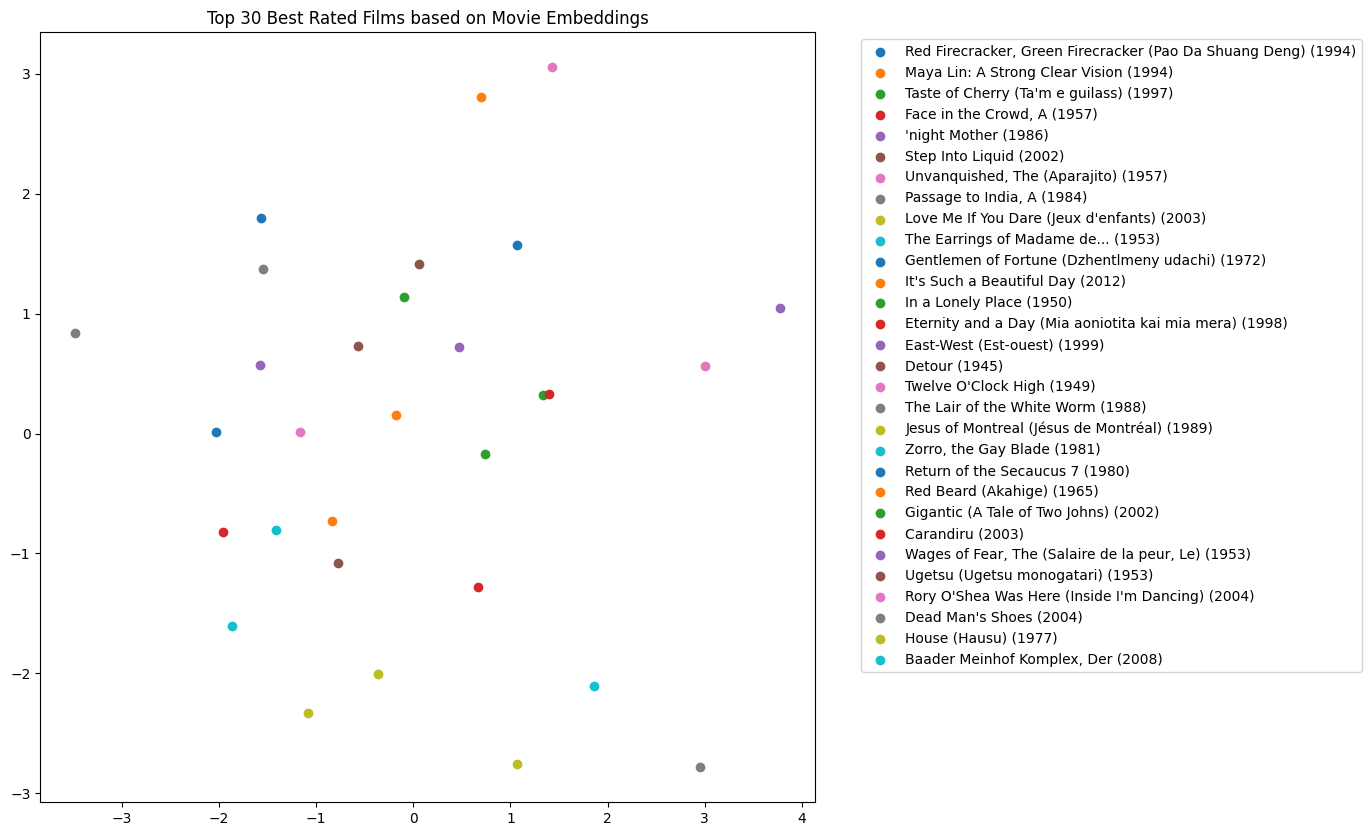

In [318]:
#for the below code I used a comination of our Term 2, intro to data science, Week 6 code and code within this stack overflow: https://stackoverflow.com/questions/20084487/use-index-in-pandas-to-plot-data
embeddings = np.array(highest_ratings['Film Embedding'].tolist())
embeddings = StandardScaler().fit_transform(embeddings) #standardize the data
titles = highest_ratings['Name'].tolist()

pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(embeddings) #get pca of our embeddings

# Plot the films on a 2-D graph
plt.figure(figsize=(10, 10))
for i in highest_ratings.index:
    x = embeddings_2d[i, 0] #getting our embeddings at index i, position 0
    y = embeddings_2d[i, 1] #getting our embeddings at index i, position 1
    title = titles[i] #getting the title at index i 
    plt.scatter(x, y, label=title) #scatter plotting it 

# Adding a title title to the plot
plt.title('Top 30 Best Rated Films based on Movie Embeddings')

# Add legend and show the plot
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left') #used code from https://www.geeksforgeeks.org/how-to-place-legend-outside-of-the-plot-in-matplotlib/
plt.show()

## Additional Work

Below is additional work I attempted when completing this project. It does not have a use or contributes to the answers above, but is included because I couldn't bear to delete the weeks of progress. 

In [ ]:
#calcualte every user's top 10
#starting with only 1 user
unique_users = set(user_ids)
#unique_users #671 unique users
user_for_test = user_ids[7]
user_top_n_test = get_top_n(user=user_for_test, n=10)
user_top_n_test

In [ ]:
indexes = get_top_n_indexes(user_for_test,10)
indexes_df = pd.DataFrame(indexes)
indexes_df

In [ ]:
import pandas as pd
import numpy as np
# let Dataset here be your data#

from sklearn.preprocessing import MinMaxScaler
minmax = MinMaxScaler()

#for x in indexes_df.columns[indexes_df.dtypes == 'int64']:
   # indexes_df[x] = minmax.fit_transform(np.array(indexes_df[0]).reshape(-1,1))

In [ ]:
#Import the euclidean distance method from sklearn
from sklearn.metrics.pairwise import nan_euclidean_distances as dist

In [ ]:
#for each top 10, get the embedding for each film and calculate the similarity matrix
simsMatrix_one_user = 1-dist(indexes_df)
users = indexes_df.index
similarities_one_user = pd.DataFrame(simsMatrix_one_user, index = users, columns = users)
similarities_one_user.style.background_gradient(cmap='Greens')

In [ ]:
#invert the similarity matrix
diversity_one_user = 1-simsMatrix_one_user
diversity_one_user = pd.DataFrame(diversity_one_user, index = users, columns = users)
diversity_one_user.style.background_gradient(cmap='Reds')

In [ ]:
#get mean difference for the top 10 
#get average similarity value
similarities_mean = similarities.mean()
similarities_mean_2 = similarities_mean.mean()
print(similarities_mean_2)

#get average diversity value
diversity_mean = diversity.mean()
diversity_mean_2 = diversity_mean.mean()
print(diversity_mean_2)

#find mean difference
difference_in_means = similarities_mean_2 - diversity_mean_2
print(difference_in_means)


In [ ]:
for index, user in enumerate(user_ids):
    if index < len(user_ids) - 1:
        for indexes in ten_films_indexes_df['Indexes']:
            movie_embeddings = {}
            for i in indexes:
                if i < len(model.movie_embedding.weight.data):
                    embeddings = model.movie_embedding.weight.data[i]
                    movie_embeddings = {'User': index, 'Film Embeddings': embeddings}

In [ ]:
#using the indexes, find the embedding for each film
#try it with one user
user = ten_films_indexes_df.iloc[0]
movie_embeddings = []
for index in user['Indexes']:
    embeddings = model.movie_embedding.weight.data[index]
    movie_embeddings.append(embeddings)
    

In [ ]:
import numpy as np

user = ten_films_indexes_df.iloc[0]
movie_embeddings = []
for index in user['Indexes']:
    embeddings = model.movie_embedding.weight.data[index]
    movie_embeddings.append(embeddings)

print(type(movie_embeddings))
ten_films_indexes_df.loc[0, 'MovieEmbeddings'] = movie_embeddings

In [ ]:
ten_films_df = pd.concat([ten_films_df, ten_films_indexes_df], axis=1)

To get the below code, I used a mixture of this: https://stackoverflow.com/questions/55193322/convert-a-python-list-of-python-lists-to-pytorch-tensor

and this: https://discuss.pytorch.org/t/how-to-turn-a-list-of-tensor-to-tensor/8868/11

In [ ]:
#DON"T NEED THIS
#converting all those values to a -1,1 scale to use in the similarity matrix
ten_films_indexes_df['Flattened Indexes'] = [[tensor.item() for tensor in sublist] for sublist in ten_films_indexes_df['Indexes']]

reshaped_indexes = []
for indexes in ten_films_indexes_df['Flattened Indexes']:
    indexes = minmax.fit_transform(np.array(indexes).reshape(-1,1))
    indexes = [item for sublist in indexes for item in sublist] #flattening our reshaped embeddings
    reshaped_indexes.append(indexes) #adding them to our list to add to our dataframe

ten_films_indexes_df['Flattened Indexes'] = reshaped_indexes
# append our dataframe with the flattened and reshaped film embeddings
ten_films_df = pd.concat([ten_films_df, ten_films_indexes_df], axis=1)

In [ ]:
embedding_df = []

for index, user in enumerate(user_ids):
    if index < len(user_ids)-1:
        user_embedding = []
        for indexes in ten_films_df['Indexes']:
            movie_embeddings = []
            for i in indexes:
                embeddings = model.movie_embedding(torch.LongTensor([i]))
                embeddings = embeddings.detach().numpy()
                movie_embeddings.append(embeddings)
            user_embedding.extend(movie_embeddings)
        embedding_df[user] = user_embedding

In [ ]:
embedding_df = []

for index, user in enumerate(user_ids):
    if index < len(user_ids)-1:
        user_embedding = []
        for indexes in ten_films_df['Indexes']:
            movie_embeddings = []
            for i in indexes:
                embeddings = model.movie_embedding(torch.LongTensor([i]))
                embeddings = embeddings.detach().numpy()
                movie_embeddings.append(embeddings)
            user_embedding.extend(movie_embeddings)
        embedding_df[user] = user_embedding

In [ ]:
embedding_list = []
for index, user in enumerate(user_ids):
    if index < len(user_ids) - 1:
        user_embedding = []
        for indexes in ten_films_df['Indexes']:
            row_embeddings = []
            print(indexes)
            embeddings = model.movie_embedding(torch.LongTensor([indexes]))
            embeddings = embeddings.detach().numpy()
            row_embeddings.append(embeddings)
            embedding_list.append(row_embeddings)

In [ ]:
embedding_list = []
for index, user in enumerate(user_ids):
    if index < len(user_ids) - 1:
        user_embedding = []
        for indexes in ten_films_df['Indexes']:
            row_embeddings = []
            for i in indexes:
                embeddings = model.movie_embedding(torch.LongTensor([i]))
                #embeddings = embeddings.detach().numpy()
                row_embeddings.append(embeddings)
            embedding_list.append(row_embeddings)

In [ ]:
modified_df = pd.DataFrame()

for idx, indexes in enumerate(ten_films_df['Indexes']):
    embeddings_list = []
    for val in indexes:
        embeddings = model.movie_embedding(torch.LongTensor([val]))
        embeddings_list.append(embeddings)
        print(embeddings_list)
    modified_df.at[idx, 'Modified Indexes'] = embeddings_list

In [ ]:
embedding_list_test = []
for indexes in ten_films_df['Indexes']:
    row_embeddings = []
    for i in indexes:
        embeddings = model.movie_embedding(torch.LongTensor([i]))
        print(embeddings)
    row_embeddings.append(embeddings)
embedding_list.append(row_embeddings)

In [ ]:

# Create a sample dataframe
ten_films_df = pd.DataFrame({'Flattened Indexes': [[1, 2, 3], [4, 5, 6], [7, 8, 9]]})

# Create an empty list to store the movie embeddings
all_movie_embeddings = []

# Define the batch size for processing
batch_size = 100

# Iterate over each row in the dataframe
for index, row in ten_films_df.iterrows():
    # Get the flattened indexes for the current row
    flattened_indexes = row['Flattened Indexes']
    print(flattened_indexes)

    # Create an empty list to store the movie embeddings for the current row
    movie_embeddings = []

    # Split the flattened indexes into smaller batches
    num_batches = len(flattened_indexes) // batch_size + 1
    for batch_idx in range(num_batches):
        start_idx = batch_idx * batch_size
        end_idx = start_idx + batch_size
        batch_indexes = flattened_indexes[start_idx:end_idx]

        # Convert batch_indexes to LongTensor
        batch_indexes = torch.LongTensor(batch_indexes)

        # Apply the embeddings model to the batch of indexes
        m_e = model.movie_embedding(batch_indexes)
        m_e = m_e.detach().numpy()
        movie_embeddings.extend(m_e.tolist())

    # Append the movie embeddings for the current row to the list of all movie embeddings
    all_movie_embeddings.append(movie_embeddings)

# Add the movie embeddings to the dataframe as a new column
ten_films_df['Movie Embeddings'] = all_movie_embeddings

# Print the updated dataframe
print(ten_films_df)

In [ ]:
# Define a function to apply our embeddings model to each row in our flattened indexes
def get_embeddings(indexes):
    # Apply the function
    movie_embeddings = model.movie_embedding(torch.LongTensor([indexes]))
    return movie_embeddings

# Apply the function to the 'Numbers' column and save the result to a new column 'Result'
ten_films_df['Movie Embeddings'] = ten_films_df['Flattened Indexes'].apply(get_embeddings)

# Print the updated dataframe
print(ten_films_df)

In [ ]:
#get the movie embeddings
movie_embeddings = []
for index, movie in enumerate(user_ids):
    movie_indexes = ten_films_df['Flattened Indexes']
    for index, row in ten_films_df.iterrows():
        if index < len(user_ids):
            m_e = model.movie_embedding(torch.LongTensor([movie_indexes]))
            m_e = m_e.detach().numpy()
            movie_embeddings.append(m_e[0])

movie_embeddings

In [ ]:
movie_embeddings_df = pd.DataFrame({'Movie Embeddings': movie_embeddings})
ten_films_df = pd.concat([ten_films_df, movie_embeddings_df], axis=1)

In [ ]:

all_movie_embeddings = []
for index, user in enumerate(user_ids):
    if index < len(user_ids):
        top_movies_indexes = get_top_n_indexes(user)

        
        #movie_embeddings = []
        #for index, movie in enumerate(top_movies_indexes):
                #if index < len(top_movies_indexes)-1:
                     #   print(movie)
                       # m_e = model.movie_embedding(torch.LongTensor([movie]))
                       # m_e = m_e.detach().numpy()
                       # movie_embeddings.append(m_e[0])
        
        # Append the movie embeddings for the current user to the list of all movie embeddings 
        #all_movie_embeddings.append(movie_embeddings)

# Create a DataFrame with the movie embeddings for all users
#movie_embeddings_df = pd.DataFrame({'Movie Embeddings': all_movie_embeddings})

In [ ]:
#num_users = # specify the total number of users
#EMBEDDING_SIZE = # specify the size of the user embedding

#user_ids = # list of user IDs to iterate over

# Create an empty list to store the movie embeddings for all users
all_movie_embeddings = []

for user in user_ids:
    # Get the user embedding for the current user
    user_embedding = model.user_embedding(torch.LongTensor([user]))

    # Retrieve the embeddings for the user's top 10 films
    top_movies = get_top_n_indexes(user) # Replace with your own logic to obtain the user's top 10 movies

    movie_embeddings = []
    for movie_id in top_movies:
        m_e = model.movie_embedding(torch.LongTensor([movie_id]))
        m_e = m_e.detach().numpy()
        movie_embeddings.append(m_e[0])

    # Append the movie embeddings for the current user to the list of all movie embeddings
    all_movie_embeddings.append(movie_embeddings)

# Create a DataFrame with the movie embeddings for all users
movie_embeddings_df = pd.DataFrame({'Movie Embeddings': all_movie_embeddings})

In [ ]:
movie_embeddings = []
for i, films in enumerate(diversity_df['Top 10 Films']):
    m_e = model.movie_embedding(torch.LongTensor([i])) 
    m_e = m_e.detach().numpy()
    movie_embeddings.append(m_e[0])

movie_embeddings_df = pd.DataFrame({'Movie Embeddings': movie_embeddings})

In [ ]:
#for each top 10, get the embedding for each film
movie_embeddings = []
for index, user in enumerate(user_ids):
    if index < len(user_ids):
        m_e = model.movie_embedding(torch.LongTensor([index])) 
        m_e = m_e.detach().numpy()
        [m_e] = m_e #get rid of the double [[]]
        movie_embeddings.append(m_e)
        
movie_embeddings_df = pd.DataFrame({'Movie Embeddings': movie_embeddings})

In [ ]:
movie_embeddings_df

In [ ]:
#first I need to translate each top 10 embeddings into a 2D array so it can be used in our distance simulators
for embeddings in movie_embeddings_df['Movie Embeddings']:
    print(embeddings.reshape(5,2))

In [ ]:
#use this to calculate the similarity matrix
#to do this, I first need to calculate the similarity matrix for each user's 10 film embeddings
# I first need to compare the top 10 embeddings
similarities_matrix = []

for index, embeddings in enumerate(movie_embeddings):
    if index < len(user_ids):
        embeddings = embeddings.reshape(-1,1)
        #print(embeddings)
     #   print(dist(movie_embeddings[index]))
        simsMatrix = 1-dist(embeddings)
users = movie_embeddings_df.index
similarities = pd.DataFrame(simsMatrix, index = users, columns = users)
similarities.style.background_gradient(cmap='Greens') 

In [ ]:
users = movie_embeddings_df.index
similarities = pd.DataFrame(simsMatrix, index = users, columns = users)
similarities.style.background_gradient(cmap='Greens') 